In [1]:
import numpy as np
import collections
import tqdm
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import sys
import random
import time

import mindspore as ms
from mindquantum.core.circuit import Circuit as HiqCircuit
from mindquantum.core.gates import ZZ, XX
from mindquantum.core.gates import H as HiqH
from mindquantum.core.operators import Hamiltonian as HiqHamiltonian
from mindquantum.core.operators import QubitOperator
# from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator

import sys
sys.path.append("/home/zoker/quict")
from QuICT.algorithm.quantum_machine_learning.data import *
from frqi import HIQFRQI
from ansatz import HIQAnsatz
from QuICT.algorithm.quantum_machine_learning.encoding import *
from QuICT.simulation.state_vector import StateVectorSimulator
from QuICT.algorithm.quantum_machine_learning.ansatz_library import *
from QuICT.core.circuit import Circuit
from QuICT.core.gate import *
from QuICT.algorithm.quantum_machine_learning.utils import Hamiltonian
from QuICT.algorithm.quantum_machine_learning.differentiator import Differentiator

Please install quict_sim first, you can use 'pip install quict_sim' to install. 
Please install pytorch, torch-geometric, torch-sparse, tensorboard, cupy and quict_ml first, you can use 'pip install quict-ml' to install quict_ml. 
Please install pytorch, cupy and quict_ml first, you can use 'pip install quict-ml' to install quict_ml. 


In [2]:
RESIZE = (4, 4)
QUBIT = int(np.log2(RESIZE[0] * RESIZE[1]) + 2)

Training examples:  60000
Testing examples:  10000
Filtered training examples:  12049
Filtered testing examples:  1968
Label:  tensor(False)
Remaining training examples:  10338
Remaining testing examples:  1793


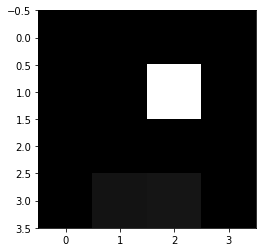

In [3]:
train_data = datasets.MNIST(root="./data/", train=True, download=True)
test_data = datasets.MNIST(root="./data/", train=False, download=True)
train_X = train_data.data
train_Y = train_data.targets
test_X = test_data.data
test_Y = test_data.targets
print("Training examples: ", len(train_Y))
print("Testing examples: ", len(test_Y))


def filter_targets(X, Y, class0=3, class1=6):
    idx = (Y == class0) | (Y == class1)
    X, Y = (X[idx], Y[idx])
    Y = Y == class1
    return X, Y


train_X, train_Y = filter_targets(train_X, train_Y)
test_X, test_Y = filter_targets(test_X, test_Y)
print("Filtered training examples: ", len(train_Y))
print("Filtered testing examples: ", len(test_Y))
print("Label: ", train_Y[200])
plt.imshow(train_X[200], cmap="gray")


def downscale(X, resize):
    transform = transforms.Resize(size=resize)
    X = transform(X) / 255.0
    return X


resized_train_X = downscale(train_X, RESIZE)
resized_test_X = downscale(test_X, RESIZE)
plt.imshow(resized_train_X[200], cmap="gray")


def remove_conflict(X, Y, resize):
    x_dict = collections.defaultdict(set)
    for x, y in zip(X, Y):
        x_dict[tuple(x.numpy().flatten())].add(y.item())
    X_rmcon = []
    Y_rmcon = []
    for x in x_dict.keys():
        if len(x_dict[x]) == 1:
            X_rmcon.append(np.array(x).reshape(resize))
            Y_rmcon.append(list(x_dict[x])[0])
    X = np.array(X_rmcon)
    Y = np.array(Y_rmcon)
    return X, Y


nocon_train_X, nocon_train_Y = remove_conflict(resized_train_X, train_Y, RESIZE)
nocon_test_X, nocon_test_Y = remove_conflict(resized_test_X, test_Y, RESIZE)
print("Remaining training examples: ", len(nocon_train_Y))
print("Remaining testing examples: ", len(nocon_test_Y))


def binary_img(X, threshold):
    X = X > threshold
    X = X.astype(np.int16)
    return X


threshold = 0.5
bin_train_X = binary_img(nocon_train_X, threshold)
bin_test_X = binary_img(nocon_test_X, threshold)


def encoding_img(X, encoding):
    data_circuits = []
    for i in tqdm.tqdm(range(len(X))):
        data_circuit = encoding(X[i])
        data_circuits.append(data_circuit)

    return data_circuits


In [4]:
BATCH_SIZE = 1  # 一次迭代使用的样本数
SEED = 17  # 随机数种子

np.random.seed(SEED)
random.seed(SEED)
ms.set_seed(SEED)

In [5]:
train_X = bin_train_X
test_X = bin_test_X
train_Y = nocon_train_Y
test_Y = nocon_test_Y

train_dataset = Dataset(train_X, train_Y)
test_dataset = Dataset(test_X, test_Y)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)

In [6]:
# Test grad
quict_frqi = FRQI(2)
hiq_frqi = HIQFRQI(RESIZE[0] * RESIZE[1])
quict_sim = StateVectorSimulator(device="GPU")
hiq_sim = Simulator('mqvector', QUBIT)
hiq_datacir = hiq_frqi()
quict_qnn = CRADL(QUBIT, color_qubit=1, readout=0)
hiq_qnn = HIQAnsatz(QUBIT, color_qubit=QUBIT - 2, readout=QUBIT - 1)
hiq_encoder = hiq_frqi()
hiq_encoder.as_encoder()
hiq_ansatz = hiq_qnn()
hiq_ansatz.as_ansatz()
hiq_cir = hiq_encoder + hiq_ansatz
differentiator = Differentiator(device="GPU")
quict_ham = Hamiltonian([[1.0, "Z0"]])
hiq_ham = HiqHamiltonian(QubitOperator("Z" + str(QUBIT - 1)))


loader = tqdm.tqdm(train_loader, leave=True)
for it, (x_train, y_train) in enumerate(loader):
    params = np.ones((1, (QUBIT - 2) * 4))
    hiq_sim.reset()
    quict_datacir = quict_frqi(x_train[0], use_qic=False)
    quict_modelcir = quict_qnn.init_circuit(params=params)
    quict_params = quict_qnn.params
    quict_cir = Circuit(QUBIT)
    quict_datacir | quict_cir(list(range(1, QUBIT)))
    sv = quict_sim.run(quict_cir)
    
    
    quict_modelcir | quict_cir(list(range(QUBIT)))
    quict_sv = quict_sim.run(quict_cir)
    quict_vars, poss = differentiator.run(quict_modelcir, quict_params, quict_sv, quict_ham)
    quict_grad = quict_vars.grads
    
    # hiq_sim.apply_circuit(hiq_cir, list(x_train[0].flatten()) + list(params[0] / 2))
    grad_ops = hiq_sim.get_expectation_with_grad(hams=hiq_ham, circ_right=hiq_cir)
    hiq_img = np.array(list(x_train[0].flatten())).reshape(1, RESIZE[0] * RESIZE[1])
    hiq_params = np.array(list(params[0] / 2))
    re = grad_ops(hiq_img, hiq_params)
    hiq_grad = re[2]
    
    # hiq_sv = hiq_sim.get_qs()
    if abs(np.linalg.norm(quict_grad*2 - hiq_grad)) > 1e-12:
        print(it)
        print("FALSE")
        print(x_train[0])
        print("quict", quict_grad)
        print("hiq", hiq_grad)
        break
print("PASS")

100%|██████████| 10338/10338 [03:35<00:00, 48.01it/s]

PASS
